# Imports

In [33]:
import torch
import librosa
from matplotlib import pyplot as plt
import numpy as np
import IPython.display as ipd
from tqdm import tqdm
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Exploration

A method to easily load audio and visually debug were necessary

In [4]:
def load_audio(path, show=False):
    # sampling rate at 16000Hz wrt flickr_audio
    x1, sr1 = librosa.load(os.path.join(path), sr=16000) 

    if(show):
        ipd.display(ipd.Audio(os.path.join(path)))
        
        t1 = np.arange(x1.shape[0]) / sr1
        plt.figure(figsize=(10, 2))
        plt.plot(t1, x1, color='gray')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.xlim([t1[0], t1[-1]])
        plt.tight_layout()
        
    return x1, sr1

A test of what the audio sounds like

(array([0.        , 0.        , 0.        , ..., 0.00735474, 0.00662231,
        0.00732422], dtype=float32),
 16000)

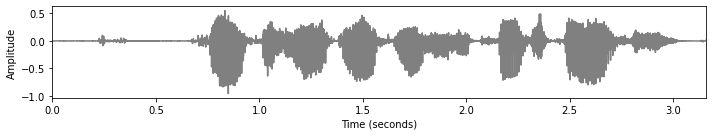

In [5]:
load_audio('flickr_audio/flickr_audio/wavs/2110692070_8aaaa1ae39_4.wav', show=True)

Path definitions

In [6]:
data = 'flickr_audio/flickr_audio/wavs/'
annotations = 'flickr_audio/flickr_audio/wav2spk.txt'

Loading data annotations and seeing how many audio files per speaker

In [7]:
from io import StringIO

s = StringIO(u"1,1.3,abcde")
speaker_annotations = np.genfromtxt(annotations, dtype=[('mystring','S27'),('myint','i8')], delimiter=' ')

print('wav file', '\t\t\t    speaker id')
for i in range(20):
    print(speaker_annotations[i][0], '\t\t', speaker_annotations[i][1])

wav file 			    speaker id
b'2571096893_694ce79768_1.wav' 		 1
b'2571096893_694ce79768_2.wav' 		 2
b'2570559405_dc93007f76_4.wav' 		 3
b'2571096893_694ce79768_0.wav' 		 4
b'2572101672_4d699c8713_0.wav' 		 4
b'2572101672_4d699c8713_1.wav' 		 5
b'2571096893_694ce79768_3.wav' 		 6
b'2571096893_694ce79768_4.wav' 		 7
b'2572101672_4d699c8713_2.wav' 		 8
b'2572101672_4d699c8713_3.wav' 		 9
b'2198484810_50a893824a_2.wav' 		 10
b'2198484810_50a893824a_3.wav' 		 11
b'3063544435_10516c6937_3.wav' 		 12
b'3063544435_10516c6937_2.wav' 		 13
b'3063544435_10516c6937_1.wav' 		 14
b'3063544435_10516c6937_0.wav' 		 15
b'306318683_5f1f875191_4.wav' 		 16
b'306318683_5f1f875191_3.wav' 		 4
b'306318683_5f1f875191_2.wav' 		 17
b'306318683_5f1f875191_1.wav' 		 18


In [13]:
from collections import Counter

speakers = Counter() # store count of songs per speaker
for x in speaker_annotations:
    speakers[x[1]] += 1
    
# Computing quick average, max, and min
counts = [count for n, count in speakers.items()]
print('average', sum(counts) / len(speakers))
print('max', max(counts))
print('min', min(counts))

print('\n\nTop 10 speakers and number of audio files:')
speakers.most_common()[:10]

average 218.5792349726776
max 2978
min 4


Top 10 speakers and number of audio files:


[(7, 2978),
 (17, 2466),
 (5, 2197),
 (4, 1690),
 (46, 1472),
 (33, 1132),
 (49, 1070),
 (19, 1050),
 (11, 858),
 (6, 837)]

## Observations

Observations taken from manually listening to wav files to check if male or female.
- Speakers 7, 17, 5. Top 3 speakers. All Male
- Speaker 4, fourth most popular. Female
- Speakers 46, 33. All Male.
- Speaker 49. Female

## Considerations

I will consider the following questions:

- Should I map male to female and vice versa via all the speakers? That would certainly provide the most data - but would it be useful? 

- Should I map all voices to one voice? That would definetely be an interesting case, target domain might suffer from relatively less data though. In such a case I should focus on voices with the largest number of data.

- Should I map one speaker to another in all combinations? Female to Male. Male to Female. Female to Female. Male to Male. That may be exhaustive, but maybe less expensive than the mapping all voices to once voice problem. The limitation here is that with 1 to 1 mappings lack  of data is something to consider. There seems to be a count gap between male and female.
    - Though worth noting, this is what Abadawi 2020 did. They used cycle consistency and VAE-GAN to help make this possible. Cycle consistency makes sense here! As the transfer is unpaired.
    - Also they had a mega NVIDA Titan X GPU, had to train 8 hours each time. Has 12 GB. Could make as deep of a model and train with 16 GB if I distribute the training across 2 GPUs! Could run 50% faster i.e. in 4 hours each time. 
    - Also need to keep in mind about WaveNet! Should import it.
    - The goal of this proposal was to reimplement this paper, and try maybe CQT transform and cascading. With only 4 hours of runtime (atleast hypothetically) that can be more than possible! Will first aim at reimplementing and well, then will extend to modifications.
    - Could also consider architectural modifications and CQT vs Mel. Can instead investigate the losses! And incorporate inception distance!

# Preprocessing

In [14]:
def get_audio_titles(speaker_id):
    titles = []    
    for a in speaker_annotations:
        if a[1] == speaker_id:
            titles.append(a[0])
    return titles

titles_speaker_7 = get_audio_titles(7)
titles_speaker_4 = get_audio_titles(4)

In [35]:
# n_fft=2048, hop_length=512 by default
def melspec_set(titles):
    melset = []
    for title in tqdm(titles):
        x, sr = load_audio(data+title.decode())
        melset.append(librosa.feature.melspectrogram(x, sr))
    return melset

melset_speaker_7 = melspec_set(titles_speaker_7)
melset_speaker_4 = melspec_set(titles_speaker_4)

100%|██████████| 1690/1690 [00:22<00:00, 76.14it/s]


A utility to save and load files with ease

In [37]:
import pickle

def save_pickle(obj, path):
    with open(path, 'wb') as fp:
        pickle.dump(obj, fp)
        
def load_pickle(path):
    with open(path, 'rb') as fp:
        return pickle.load(fp)

In [ ]:
save_pickle(melset_speaker_7, 'pool/melset_speaker_7.pickle')
save_pickle(melset_speaker_4, 'pool/melset_speaker_4.pickle')

In [ ]:
melset_speaker_7 = load_pickle('pool/melset_speaker_7.pickle')
melset_speaker_4 = load_pickle('pool/melset_speaker_4.pickle')